In [1]:
import os
from nipype.interfaces import fsl
from nipype.interfaces.io import SelectFiles, DataSink
import nipype.pipeline.engine as pe
import nipype.interfaces.utility as util
import nipype.algorithms.modelgen as model
from config import root
from IPython.display import Image

fsl.FSLCommand.set_default_output_type("NIFTI_GZ")

In [3]:
def make_contrasts(contrasts, names, con_type="T", show_output=True):
    """Make contrasts as read into FSL"""

    contrasts_fmt = []
    for contrast in contrasts:

        # create contrast title
        title_left, title_right = [], []
        for k, v in contrast.items():
            title_left += [k] if v > 0 else []
            title_right += [k] if v < 0 else []
        title = ", ".join(title_left) + " > " + ", ".join(title_right)

        weights_per_regr = []
        for name in names:
            weight = contrast[name] if name in contrast.keys() else 0
            weights_per_regr.append(weight)

        contrasts_fmt.append((title, con_type, names, weights_per_regr))

    if show_output:
        for con in contrasts_fmt:
            print("="*20)
            print(con[0])
            print("-"*20)
            print(con[1])
            for reg, weight in zip(con[2], con[3]):
                print(reg, "\t", weight)
            print("="*20)
            print("\n")

    return contrasts_fmt

def pop_decay_per_location(in_file="", duration=.2, **kwargs):

    from nipype.interfaces.base import Bunch
    import pandas as pd

    # the data
    regs = pd.read_csv(in_file, header=0)
    conditions = regs.columns.tolist()
    conditions.remove("onset")
    onsets = [regs.onset] * len(conditions)
    durations = [ [duration] * len(regs) ] * len(conditions)
    amplitudes = regs[conditions].values.T.tolist()
    
    output = Bunch(conditions=conditions, onsets=onsets,
                   durations=durations, amplitudes=amplitudes)

    return output

# Prepare

In [4]:
# pathnames
base_dir = os.path.join(root, "data")
output_dir = os.path.join(root, "data", "output")
working_dir = os.path.join(root, "data", "working_dir")

# MNI standard file
standard = os.path.join(root, "data", "in_analysis", "nii", "standard")
mni_standard_path = os.path.join(standard, "MNI152_T1_2mm_brain.nii.gz")
mni_brain_standard_path = os.path.join(standard, "MNI152_T1_2mm_brain.nii.gz")
mni_brain_mask_standard_path = os.path.join(standard, "MNI152_T1_2mm_brain_mask.nii.gz")

NameError: name 'os' is not defined

In [5]:
# Params
glm_prefix = "pop_decay_submean_"
TR = 2.1
filter_cutoff = 60

# Lists
sub_list = ["sub_%03d" % i for i in range(1, 7)]

## Input and output nodes

In [2]:
# iterate over subjects
infosource = pe.Node(
    util.IdentityInterface(
        fields=["sub_id"]),
    name="infosource")

# Define iterable attributes
infosource.iterables = [("sub_id", sub_list)]

# File templates for different subjects and sessions
templates = {
    "runs"       : "output/highpass/ses_*{sub_id}/_hp_filter*/run_*_st_mcf_warp_dtype_bet_intnorm_smooth_hpf.nii.gz",    
#     "runs"       : "output/subtractmean/ses_*{sub_id}/_subtractmean*/run_*_st_mcf_warp_dtype_bet_intnorm_smooth_hpf_sub.nii.gz",
    "behavior"   : "search/regs/{sub_id}_ses_*_scn_*.txt",
    "func1"      : "output/highpass/ses_000{sub_id}/_hp_filter0/run_000_st_mcf_warp_dtype_bet_intnorm_smooth_hpf.nii.gz",
    "warp_field" : "output/register_to_standard/{sub_id}/orig_field.nii.gz", 
    "premat"     : "output/register_to_standard/{sub_id}/inplane_brain_bbreg_{sub_id}.mat",
}

# SelectFiles Node to handle session specific file templates
files = pe.Node(
    SelectFiles(
        templates,
        base_directory=base_dir,
        sort_filelist=True),
    name="files")

# Create datasink to store important
# files in useful, more accessable locations.
datasink = pe.Node(
    DataSink(
        base_directory=base_dir,
        container="output"),
    name="datasink")

# Remove unwanted lengthy strings from filenames.
datasink.inputs.substitutions = [("_sub_id_", "")]

NameError: name 'pe' is not defined

## Make contrasts

In [8]:
contrasts = [{
    'loc1': 1,
    'loc2': -0.3333333333333333,
    'loc3': -0.3333333333333333,
    'loc4': -0.3333333333333333
}, {
    'loc2': 1,
    'loc1': -0.3333333333333333,
    'loc3': -0.3333333333333333,
    'loc4': -0.3333333333333333
}, {
    'loc3': 1,
    'loc1': -0.3333333333333333,
    'loc2': -0.3333333333333333,
    'loc4': -0.3333333333333333
}, {
    'loc4': 1,
    'loc1': -0.3333333333333333,
    'loc2': -0.3333333333333333,
    'loc3': -0.3333333333333333
}, {
    'loc_lag1': 0.5, 
    'loc_lag2': 0.5,
}, {
    'loc_lag1': 1.0
}, {
    'loc_lag2': 1.0,
}, {
    'clr_lag1': 0.5, 
    'clr_lag2': 0.5,
}, {
    'clr_lag1': 1.0
}, {
    'clr_lag2': 1.0
}, {
    'loc1': 0.25, 
    'loc2': 0.25, 
    'loc3': 0.25, 
    'loc4': 0.25
}]

conditions = ["loc1", "loc2", "loc3", "loc4",
              "loc_lag1", "loc_lag2",
              "clr_lag1", "clr_lag2"]

# Create contrasts for FSL
contrasts_large = make_contrasts(contrasts, conditions, show_output=True)

loc1 > loc2, loc3, loc4
--------------------
T
loc1 	 1
loc2 	 -0.3333333333333333
loc3 	 -0.3333333333333333
loc4 	 -0.3333333333333333
loc_lag1 	 0
loc_lag2 	 0
clr_lag1 	 0
clr_lag2 	 0


loc2 > loc1, loc3, loc4
--------------------
T
loc1 	 -0.3333333333333333
loc2 	 1
loc3 	 -0.3333333333333333
loc4 	 -0.3333333333333333
loc_lag1 	 0
loc_lag2 	 0
clr_lag1 	 0
clr_lag2 	 0


loc3 > loc1, loc2, loc4
--------------------
T
loc1 	 -0.3333333333333333
loc2 	 -0.3333333333333333
loc3 	 1
loc4 	 -0.3333333333333333
loc_lag1 	 0
loc_lag2 	 0
clr_lag1 	 0
clr_lag2 	 0


loc4 > loc1, loc2, loc3
--------------------
T
loc1 	 -0.3333333333333333
loc2 	 -0.3333333333333333
loc3 	 -0.3333333333333333
loc4 	 1
loc_lag1 	 0
loc_lag2 	 0
clr_lag1 	 0
clr_lag2 	 0


loc_lag1, loc_lag2 > 
--------------------
T
loc1 	 0
loc2 	 0
loc3 	 0
loc4 	 0
loc_lag1 	 0.5
loc_lag2 	 0.5
clr_lag1 	 0
clr_lag2 	 0


loc_lag1 > 
--------------------
T
loc1 	 0
loc2 	 0
loc3 	 0
loc4 	 0
loc_lag1 	 1.0
loc_lag2 	 

## Setup GLM

In [7]:
glm_function = pe.MapNode(
    util.Function(
        input_names=["in_file"],
        output_names=["subject_info"],
        function=pop_decay),
    iterfield=["in_file"],
    name=glm_prefix+"glm_function")

# Specify model
specifymodel = pe.Node(
    model.SpecifyModel(
        high_pass_filter_cutoff=filter_cutoff,
        time_repetition=TR,
        input_units="secs",
    ), 
    name=glm_prefix+"specifymodel"
)

# Level 1 design
level1design = pe.Node(
    fsl.Level1Design(
        bases={"dgamma" : {"derivs": True}},
        interscan_interval=TR,
        model_serial_correlations=True, # Prewhitening
        contrasts=contrasts_large,
    ), 
    name=glm_prefix+"level1design"
)

# model
featmodel = pe.MapNode(
    interface=fsl.FEATModel(),
    name=glm_prefix+"featmodel_ses1",
    iterfield=["fsf_file", "ev_files"]
)

# FILMGLS
filmgls = pe.MapNode(
    interface=fsl.FILMGLS(
        threshold=-1500,
    ),
    iterfield=["design_file", "in_file", "tcon_file"],
    name=glm_prefix+"filmgls"
)

180609-11:43:47,399 workflow INFO:
	 Generated workflow graph: ./graph_hierarchical.png (graph2use=hierarchical, simple_form=True).


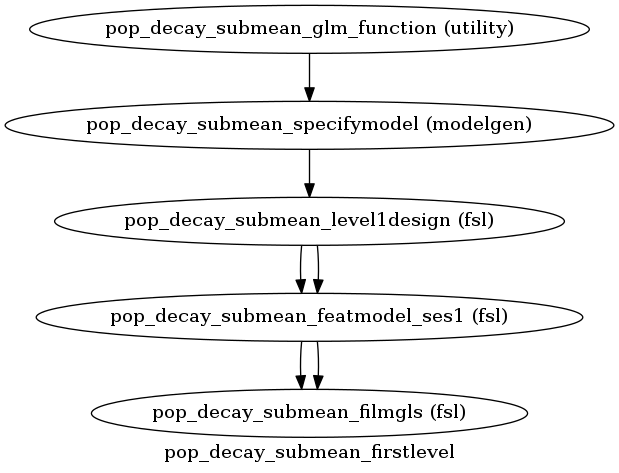

In [8]:
firstlevel = pe.Workflow(name=glm_prefix+"firstlevel", base_dir=working_dir)

firstlevel.connect(glm_function, "subject_info", specifymodel, "subject_info")
firstlevel.connect(specifymodel, "session_info", level1design, "session_info")
firstlevel.connect(level1design, "fsf_files", featmodel, "fsf_file")
firstlevel.connect(level1design, "ev_files", featmodel, "ev_files")
firstlevel.connect(featmodel, "design_file", filmgls, "design_file")
firstlevel.connect(featmodel, "con_file", filmgls, "tcon_file")

firstlevel.write_graph(simple_form=True, graph2use="hierarchical", dotfilename="./graph_hierarchical.dot")

# Visualize graph
Image(width=768, filename="graph_hierarchical.png")

## Second level

In [9]:
num_contrasts = len(contrasts)
con_list = ["%d" % (i+1) for i in range(num_contrasts)]

In [10]:
meanfunc = pe.Node(
    interface=fsl.ImageMaths(
        op_string="-Tmean",
        suffix="_mean"),
    name="meanfunc")

meanfuncmask = pe.Node(
    interface=fsl.BET(
        mask=True,
        no_output=True,
        frac=0.05),
    name="meanfuncmask")

dilatemask = pe.Node(
    interface=fsl.ImageMaths(
        suffix="_dil",
        op_string="-dilF"),
    name="dilatemask")

# Concatenate copes before feeding to Flameo
merge_copes = pe.MapNode(
    interface=fsl.Merge(
        dimension="t"),
    iterfield=["in_files"],
    name="merge_copes")

merge_varcopes = pe.MapNode(
    interface=fsl.Merge(
        dimension="t"),
    iterfield=["in_files"],
    name="merge_varcopes")

# Create a level2 model
l2model_fixed = pe.Node(
    interface=fsl.L2Model(), 
    name="l2model_fixed")

# A fixed effects FLAMEO node, with copes and varcopes as inputs.
fixed_flameo = pe.MapNode(
    interface=fsl.FLAMEO(
        run_mode="fe"),
    iterfield=["cope_file", "var_cope_file"],
    name="fixed_flameo")

applywarp_copes = pe.MapNode(
    fsl.ApplyWarp(
        ref_file=mni_standard_path),
    iterfield=["in_file"],
    name="applywarp_copes",
    overwrite=False)

applywarp_varcopes = pe.MapNode(
    fsl.ApplyWarp(
        ref_file=mni_standard_path),
    iterfield=["in_file"],
    name="applywarp_varcopes",
    overwrite=False)

applywarp_zstats = pe.MapNode(
    fsl.ApplyWarp(
        ref_file=mni_standard_path),
    iterfield=['in_file'],
    name='applywarp_zstats',
    overwrite=False)

180609-11:43:50,490 workflow INFO:
	 Generated workflow graph: ./graph_hierarchical.png (graph2use=hierarchical, simple_form=True).


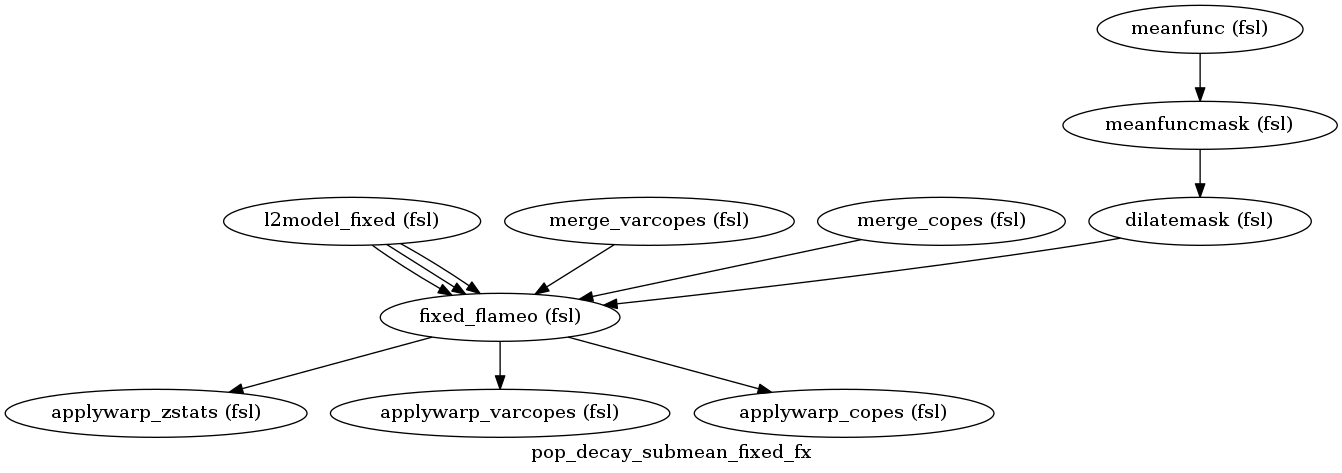

In [11]:
fixed_fx = pe.Workflow(name=glm_prefix+"fixed_fx", base_dir=working_dir)

def num_copes(files):
    return len(files)

fixed_fx.connect(meanfunc, "out_file", meanfuncmask, "in_file")
fixed_fx.connect(meanfuncmask, "mask_file", dilatemask, "in_file")
fixed_fx.connect(dilatemask, "out_file", fixed_flameo, "mask_file")
fixed_fx.connect(merge_copes, "merged_file", fixed_flameo, "cope_file")
fixed_fx.connect(merge_varcopes, "merged_file", fixed_flameo, "var_cope_file")
fixed_fx.connect(l2model_fixed, "design_mat", fixed_flameo, "design_file")
fixed_fx.connect(l2model_fixed, "design_con", fixed_flameo, "t_con_file")
fixed_fx.connect(l2model_fixed, "design_grp", fixed_flameo, "cov_split_file")
fixed_fx.connect(fixed_flameo, "copes", applywarp_copes, "in_file")
fixed_fx.connect(fixed_flameo, "var_copes", applywarp_varcopes, "in_file")
fixed_fx.connect(fixed_flameo, "zstats", applywarp_zstats, "in_file")

fixed_fx.write_graph(simple_form=True, graph2use="hierarchical", dotfilename="./graph_hierarchical.dot")
Image(width=768, filename="graph_hierarchical.png")

180609-11:43:52,949 workflow INFO:
	 Generated workflow graph: ./graph_hierarchical.png (graph2use=hierarchical, simple_form=True).


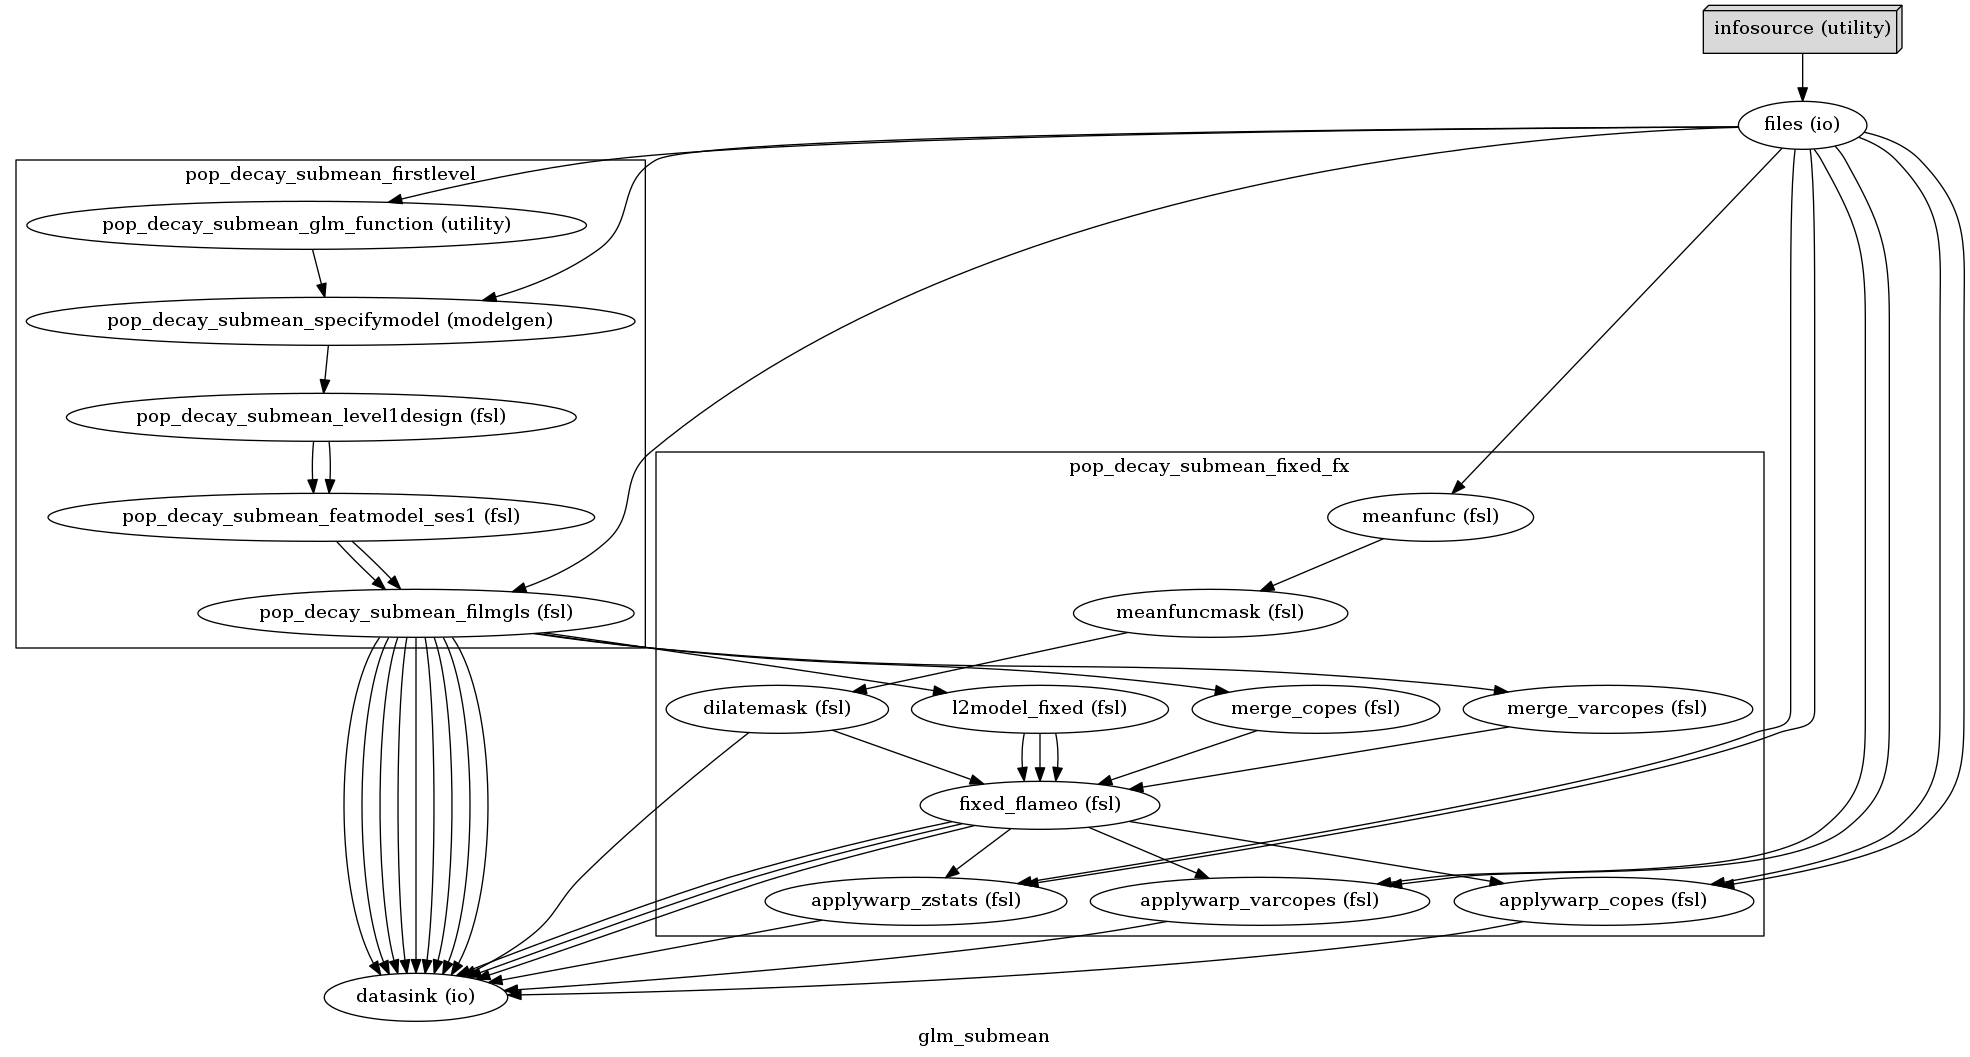

In [12]:
glm = pe.Workflow(name="glm_submean", base_dir=working_dir)

# Inputs first level
glm.connect(files, "behavior", firstlevel, glm_prefix+"glm_function.in_file")
glm.connect(files, "runs", firstlevel, glm_prefix+"specifymodel.functional_runs")
glm.connect(files, "runs", firstlevel, glm_prefix+"filmgls.in_file")
glm.connect(files, "func1", fixed_fx, "meanfunc.in_file")

# Inputs warp
glm.connect(infosource, "sub_id", files, "sub_id")
glm.connect(files, "premat", fixed_fx, "applywarp_copes.premat")
glm.connect(files, "warp_field", fixed_fx, "applywarp_copes.field_file")
glm.connect(files, "premat", fixed_fx, "applywarp_varcopes.premat")
glm.connect(files, "warp_field", fixed_fx, "applywarp_varcopes.field_file")
glm.connect(files, "premat", fixed_fx, "applywarp_zstats.premat")
glm.connect(files, "warp_field", fixed_fx, "applywarp_zstats.field_file")

def sort_copes(files):
    numelements = len(files[0])
    outfiles = []
    for i in range(numelements):
        outfiles.insert(i,[])
        for j, elements in enumerate(files):
            outfiles[i].append(elements[i])
    return outfiles

def num_copes(files):
    return len(files)

# Connect first to second level
glm.connect(firstlevel, (glm_prefix+"filmgls.copes", sort_copes), fixed_fx, "merge_copes.in_files")
glm.connect(firstlevel, (glm_prefix+"filmgls.varcopes", sort_copes), fixed_fx, "merge_varcopes.in_files")
glm.connect(firstlevel, (glm_prefix+"filmgls.copes", num_copes), fixed_fx, "l2model_fixed.num_copes")

# Outputs Level 1
glm.connect(firstlevel, glm_prefix+"filmgls.zstats", datasink, glm_prefix+"filmgls.@zstats")
glm.connect(firstlevel, glm_prefix+"filmgls.param_estimates", datasink, glm_prefix+"filmgls.@param_estimates")
glm.connect(firstlevel, glm_prefix+"filmgls.copes", datasink, glm_prefix+"filmgls.@copes")
glm.connect(firstlevel, glm_prefix+"filmgls.varcopes", datasink, glm_prefix+"filmgls.@varcopes")
glm.connect(firstlevel, glm_prefix+"filmgls.dof_file", datasink, glm_prefix+"filmgls.@dof_file")
glm.connect(firstlevel, glm_prefix+"filmgls.logfile", datasink, glm_prefix+"filmgls.@logfile")
glm.connect(firstlevel, glm_prefix+"filmgls.residual4d", datasink, glm_prefix+"filmgls.@residual4d")
glm.connect(firstlevel, glm_prefix+"filmgls.sigmasquareds", datasink, glm_prefix+"filmgls.@sigmasquareds")
glm.connect(firstlevel, glm_prefix+"filmgls.tstats", datasink, glm_prefix+"filmgls.@tstats")

# Outputs Level 2
glm.connect(fixed_fx, "dilatemask.out_file", datasink, glm_prefix + "L2_fixedfx"+".funcmask")
glm.connect(fixed_fx, "fixed_flameo.copes", datasink, glm_prefix + "L2_fixedfx"+".copes")
glm.connect(fixed_fx, "fixed_flameo.var_copes", datasink, glm_prefix + "L2_fixedfx"+".varcopes")
glm.connect(fixed_fx, "fixed_flameo.zstats", datasink, glm_prefix + "L2_fixedfx"+".zstats")
glm.connect(fixed_fx, "applywarp_copes.out_file", datasink, glm_prefix + "L2_fixedfx"+"_warped"+".copes")
glm.connect(fixed_fx, "applywarp_varcopes.out_file", datasink, glm_prefix + "L2_fixedfx"+"_warped"+".varcopes")
glm.connect(fixed_fx, "applywarp_zstats.out_file", datasink, glm_prefix + "L2_fixedfx"+"_warped"+".zstats")

glm.write_graph(
    simple_form=True, 
    graph2use="hierarchical", 
    dotfilename="./graph_hierarchical.dot"
)

Image(width=768, filename="graph_hierarchical.png")

In [ ]:
glm.run(plugin='MultiProc')